<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:32] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


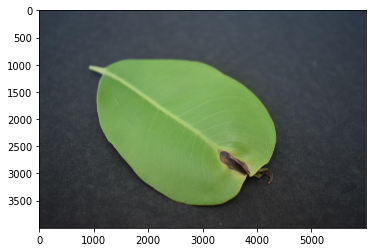

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

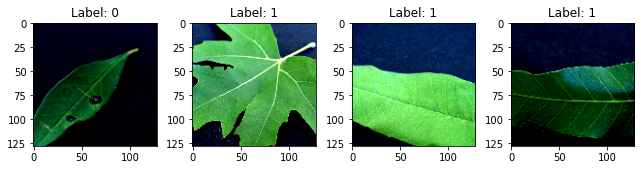

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:37] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:39] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2544665822839327 samples/sec                   batch loss = 0.8911060094833374 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2578921651579078 samples/sec                   batch loss = 1.2182693481445312 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2662074657655933 samples/sec                   batch loss = 0.989301860332489 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2580795910127915 samples/sec                   batch loss = 0.5544307231903076 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2380169698454473 samples/sec                   batch loss = 0.55296391248703 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.263200090290877 samples/sec                   batch loss = 0.786422848701477 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2606394245721362 samples/sec                   batch loss = 0.47524046897888184 | accuracy = 0.5285714285714286


Epoch[1] Batch[40] Speed: 1.2472991269836313 samples/sec                   batch loss = 0.8746832013130188 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.264505962290818 samples/sec                   batch loss = 0.5484343767166138 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.2664460359926621 samples/sec                   batch loss = 0.47596150636672974 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2682422088432468 samples/sec                   batch loss = 0.5622880458831787 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.2694440274475431 samples/sec                   batch loss = 0.8182729482650757 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.2754190899279374 samples/sec                   batch loss = 0.4415132701396942 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.2697196609815713 samples/sec                   batch loss = 0.6757837533950806 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.2659639224923436 samples/sec                   batch loss = 0.36748450994491577 | accuracy = 0.5933333333333334


Epoch[1] Batch[80] Speed: 1.270132806925568 samples/sec                   batch loss = 0.4268493950366974 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2722329649463648 samples/sec                   batch loss = 0.8529919385910034 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2662894641423623 samples/sec                   batch loss = 0.7022402286529541 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.269101597775088 samples/sec                   batch loss = 0.3998967707157135 | accuracy = 0.5973684210526315


Epoch[1] Batch[100] Speed: 1.2674205570142292 samples/sec                   batch loss = 0.5330427289009094 | accuracy = 0.5975


Epoch[1] Batch[105] Speed: 1.2740656295205794 samples/sec                   batch loss = 1.6074795722961426 | accuracy = 0.5928571428571429


Epoch[1] Batch[110] Speed: 1.2679344437133004 samples/sec                   batch loss = 0.5541377663612366 | accuracy = 0.5954545454545455


Epoch[1] Batch[115] Speed: 1.2710154629006447 samples/sec                   batch loss = 0.4903062880039215 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.2692884419902477 samples/sec                   batch loss = 0.9280981421470642 | accuracy = 0.6


Epoch[1] Batch[125] Speed: 1.270675649617651 samples/sec                   batch loss = 0.49141624569892883 | accuracy = 0.602


Epoch[1] Batch[130] Speed: 1.2725133821903818 samples/sec                   batch loss = 0.587570071220398 | accuracy = 0.6115384615384616


Epoch[1] Batch[135] Speed: 1.2692297712064442 samples/sec                   batch loss = 0.9242543578147888 | accuracy = 0.6055555555555555


Epoch[1] Batch[140] Speed: 1.267318116848595 samples/sec                   batch loss = 0.2976354956626892 | accuracy = 0.6017857142857143


Epoch[1] Batch[145] Speed: 1.2664275856488283 samples/sec                   batch loss = 0.720551609992981 | accuracy = 0.5982758620689655


Epoch[1] Batch[150] Speed: 1.2752344107127738 samples/sec                   batch loss = 0.4899587035179138 | accuracy = 0.6


Epoch[1] Batch[155] Speed: 1.2702232004109604 samples/sec                   batch loss = 0.4681839942932129 | accuracy = 0.6048387096774194


Epoch[1] Batch[160] Speed: 1.2711849561285071 samples/sec                   batch loss = 1.2796036005020142 | accuracy = 0.60625


Epoch[1] Batch[165] Speed: 1.2699087058133927 samples/sec                   batch loss = 2.3971617221832275 | accuracy = 0.6


Epoch[1] Batch[170] Speed: 1.26610206853375 samples/sec                   batch loss = 0.7662436962127686 | accuracy = 0.6044117647058823


Epoch[1] Batch[175] Speed: 1.2666117307859996 samples/sec                   batch loss = 0.8741423487663269 | accuracy = 0.6057142857142858


Epoch[1] Batch[180] Speed: 1.2752404204279073 samples/sec                   batch loss = 0.3269228935241699 | accuracy = 0.6111111111111112


Epoch[1] Batch[185] Speed: 1.2694524800954956 samples/sec                   batch loss = 0.516394853591919 | accuracy = 0.6135135135135135


Epoch[1] Batch[190] Speed: 1.2720115940578558 samples/sec                   batch loss = 1.4459644556045532 | accuracy = 0.6144736842105263


Epoch[1] Batch[195] Speed: 1.2698950565636085 samples/sec                   batch loss = 0.46161776781082153 | accuracy = 0.6192307692307693


Epoch[1] Batch[200] Speed: 1.2678640170813704 samples/sec                   batch loss = 0.11096704751253128 | accuracy = 0.62625


Epoch[1] Batch[205] Speed: 1.2702501286171322 samples/sec                   batch loss = 0.6801058053970337 | accuracy = 0.6280487804878049


Epoch[1] Batch[210] Speed: 1.269175618373783 samples/sec                   batch loss = 0.5056113600730896 | accuracy = 0.6309523809523809


Epoch[1] Batch[215] Speed: 1.2674359723417408 samples/sec                   batch loss = 1.6634891033172607 | accuracy = 0.6337209302325582


Epoch[1] Batch[220] Speed: 1.2725918555321534 samples/sec                   batch loss = 0.5758183002471924 | accuracy = 0.6375


Epoch[1] Batch[225] Speed: 1.2655204539552078 samples/sec                   batch loss = 0.41262492537498474 | accuracy = 0.6377777777777778


Epoch[1] Batch[230] Speed: 1.270640715948392 samples/sec                   batch loss = 0.42973530292510986 | accuracy = 0.6391304347826087


Epoch[1] Batch[235] Speed: 1.2734373363346305 samples/sec                   batch loss = 0.570513904094696 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2735279107921011 samples/sec                   batch loss = 0.8867025971412659 | accuracy = 0.6322916666666667


Epoch[1] Batch[245] Speed: 1.2718622243057875 samples/sec                   batch loss = 0.35515594482421875 | accuracy = 0.6346938775510204


Epoch[1] Batch[250] Speed: 1.261688422245739 samples/sec                   batch loss = 0.5518983006477356 | accuracy = 0.637


Epoch[1] Batch[255] Speed: 1.2653080925580902 samples/sec                   batch loss = 0.3387281596660614 | accuracy = 0.638235294117647


Epoch[1] Batch[260] Speed: 1.2712473718395774 samples/sec                   batch loss = 0.5593414306640625 | accuracy = 0.6375


Epoch[1] Batch[265] Speed: 1.2711968994014837 samples/sec                   batch loss = 0.37197592854499817 | accuracy = 0.6377358490566037


Epoch[1] Batch[270] Speed: 1.270746677710919 samples/sec                   batch loss = 0.8052480220794678 | accuracy = 0.6388888888888888


Epoch[1] Batch[275] Speed: 1.2679517880709017 samples/sec                   batch loss = 0.33546876907348633 | accuracy = 0.6381818181818182


Epoch[1] Batch[280] Speed: 1.2710660172295147 samples/sec                   batch loss = 0.6273331642150879 | accuracy = 0.6348214285714285


Epoch[1] Batch[285] Speed: 1.272683275183246 samples/sec                   batch loss = 0.4312697649002075 | accuracy = 0.6350877192982456


Epoch[1] Batch[290] Speed: 1.2711346812627446 samples/sec                   batch loss = 0.3669695556163788 | accuracy = 0.6379310344827587


Epoch[1] Batch[295] Speed: 1.2700068544817371 samples/sec                   batch loss = 0.6908125877380371 | accuracy = 0.6406779661016949


Epoch[1] Batch[300] Speed: 1.2661738284778805 samples/sec                   batch loss = 0.5725928544998169 | accuracy = 0.6391666666666667


Epoch[1] Batch[305] Speed: 1.2681431824594707 samples/sec                   batch loss = 0.5353577733039856 | accuracy = 0.6385245901639345


Epoch[1] Batch[310] Speed: 1.2704727147214745 samples/sec                   batch loss = 1.2094128131866455 | accuracy = 0.6395161290322581


Epoch[1] Batch[315] Speed: 1.2671650618910433 samples/sec                   batch loss = 0.41196486353874207 | accuracy = 0.6404761904761904


Epoch[1] Batch[320] Speed: 1.2690523514986947 samples/sec                   batch loss = 0.3853377401828766 | accuracy = 0.6421875


Epoch[1] Batch[325] Speed: 1.2731620188415231 samples/sec                   batch loss = 1.0716239213943481 | accuracy = 0.6423076923076924


Epoch[1] Batch[330] Speed: 1.2790876624636556 samples/sec                   batch loss = 0.6714619994163513 | accuracy = 0.6424242424242425


Epoch[1] Batch[335] Speed: 1.274259164586791 samples/sec                   batch loss = 0.7902231216430664 | accuracy = 0.6417910447761194


Epoch[1] Batch[340] Speed: 1.2677173440042775 samples/sec                   batch loss = 0.6612588763237 | accuracy = 0.6404411764705882


Epoch[1] Batch[345] Speed: 1.274105686454047 samples/sec                   batch loss = 0.3869738280773163 | accuracy = 0.6427536231884058


Epoch[1] Batch[350] Speed: 1.2708415867158505 samples/sec                   batch loss = 0.4854511022567749 | accuracy = 0.6421428571428571


Epoch[1] Batch[355] Speed: 1.2718260684069418 samples/sec                   batch loss = 0.6985294818878174 | accuracy = 0.6408450704225352


Epoch[1] Batch[360] Speed: 1.2689309320792985 samples/sec                   batch loss = 0.2929893434047699 | accuracy = 0.6430555555555556


Epoch[1] Batch[365] Speed: 1.2740146428165164 samples/sec                   batch loss = 0.6164582967758179 | accuracy = 0.6431506849315068


Epoch[1] Batch[370] Speed: 1.2715303421340411 samples/sec                   batch loss = 0.6064048409461975 | accuracy = 0.643918918918919


Epoch[1] Batch[375] Speed: 1.2681011033252134 samples/sec                   batch loss = 0.6628636121749878 | accuracy = 0.6433333333333333


Epoch[1] Batch[380] Speed: 1.269501757431809 samples/sec                   batch loss = 0.4507177770137787 | accuracy = 0.6440789473684211


Epoch[1] Batch[385] Speed: 1.2699478288804233 samples/sec                   batch loss = 0.6969877481460571 | accuracy = 0.6441558441558441


Epoch[1] Batch[390] Speed: 1.2684553645475032 samples/sec                   batch loss = 0.26763054728507996 | accuracy = 0.6435897435897436


Epoch[1] Batch[395] Speed: 1.2677363109174515 samples/sec                   batch loss = 0.729912519454956 | accuracy = 0.6430379746835443


Epoch[1] Batch[400] Speed: 1.266954731475434 samples/sec                   batch loss = 0.38231754302978516 | accuracy = 0.64375


Epoch[1] Batch[405] Speed: 1.2676372677385142 samples/sec                   batch loss = 0.586094081401825 | accuracy = 0.645679012345679


Epoch[1] Batch[410] Speed: 1.2707887400947433 samples/sec                   batch loss = 0.7798690795898438 | accuracy = 0.6463414634146342


Epoch[1] Batch[415] Speed: 1.2714562393389877 samples/sec                   batch loss = 0.5350882411003113 | accuracy = 0.6469879518072289


Epoch[1] Batch[420] Speed: 1.2699536927419262 samples/sec                   batch loss = 0.5082835555076599 | accuracy = 0.6482142857142857


Epoch[1] Batch[425] Speed: 1.2701912727316225 samples/sec                   batch loss = 0.5101863145828247 | accuracy = 0.65


Epoch[1] Batch[430] Speed: 1.267925436333573 samples/sec                   batch loss = 0.792586624622345 | accuracy = 0.6517441860465116


Epoch[1] Batch[435] Speed: 1.2687291297047658 samples/sec                   batch loss = 0.6821403503417969 | accuracy = 0.653448275862069


Epoch[1] Batch[440] Speed: 1.266975971868768 samples/sec                   batch loss = 0.7258754968643188 | accuracy = 0.6539772727272727


Epoch[1] Batch[445] Speed: 1.2682906252402535 samples/sec                   batch loss = 0.8681837320327759 | accuracy = 0.6550561797752809


Epoch[1] Batch[450] Speed: 1.272254189732312 samples/sec                   batch loss = 0.5754204988479614 | accuracy = 0.6555555555555556


Epoch[1] Batch[455] Speed: 1.2700327159606923 samples/sec                   batch loss = 0.9506323337554932 | accuracy = 0.6554945054945055


Epoch[1] Batch[460] Speed: 1.2645040561665617 samples/sec                   batch loss = 0.4638770818710327 | accuracy = 0.6570652173913043


Epoch[1] Batch[465] Speed: 1.2692325557855213 samples/sec                   batch loss = 0.466655969619751 | accuracy = 0.6586021505376344


Epoch[1] Batch[470] Speed: 1.268926709213271 samples/sec                   batch loss = 1.158121109008789 | accuracy = 0.6585106382978724


Epoch[1] Batch[475] Speed: 1.272594558353478 samples/sec                   batch loss = 0.6294379830360413 | accuracy = 0.6584210526315789


Epoch[1] Batch[480] Speed: 1.2739580494515945 samples/sec                   batch loss = 0.3663376569747925 | accuracy = 0.6609375


Epoch[1] Batch[485] Speed: 1.2695783225981427 samples/sec                   batch loss = 0.5571032762527466 | accuracy = 0.6634020618556701


Epoch[1] Batch[490] Speed: 1.2685044685910254 samples/sec                   batch loss = 0.7477550506591797 | accuracy = 0.6627551020408163


Epoch[1] Batch[495] Speed: 1.2718626099797894 samples/sec                   batch loss = 0.25556662678718567 | accuracy = 0.6641414141414141


Epoch[1] Batch[500] Speed: 1.2707528377029338 samples/sec                   batch loss = 0.40333789587020874 | accuracy = 0.664


Epoch[1] Batch[505] Speed: 1.2741513583013762 samples/sec                   batch loss = 0.9394910931587219 | accuracy = 0.6633663366336634


Epoch[1] Batch[510] Speed: 1.2685667172665307 samples/sec                   batch loss = 0.8053076267242432 | accuracy = 0.6622549019607843


Epoch[1] Batch[515] Speed: 1.270493014915246 samples/sec                   batch loss = 0.32413360476493835 | accuracy = 0.6635922330097087


Epoch[1] Batch[520] Speed: 1.273000980934899 samples/sec                   batch loss = 0.20115315914154053 | accuracy = 0.6639423076923077


Epoch[1] Batch[525] Speed: 1.2724095381327363 samples/sec                   batch loss = 0.5784254670143127 | accuracy = 0.6642857142857143


Epoch[1] Batch[530] Speed: 1.2721598413342818 samples/sec                   batch loss = 0.8367707133293152 | accuracy = 0.6636792452830189


Epoch[1] Batch[535] Speed: 1.274377733853317 samples/sec                   batch loss = 1.1170384883880615 | accuracy = 0.6635514018691588


Epoch[1] Batch[540] Speed: 1.2751116116809573 samples/sec                   batch loss = 0.23662376403808594 | accuracy = 0.6648148148148149


Epoch[1] Batch[545] Speed: 1.2684534464979544 samples/sec                   batch loss = 0.4364311397075653 | accuracy = 0.6660550458715596


Epoch[1] Batch[550] Speed: 1.26778248527054 samples/sec                   batch loss = 0.6896466016769409 | accuracy = 0.6672727272727272


Epoch[1] Batch[555] Speed: 1.2693429885988334 samples/sec                   batch loss = 0.48962870240211487 | accuracy = 0.6684684684684684


Epoch[1] Batch[560] Speed: 1.2682256234820626 samples/sec                   batch loss = 0.5951437950134277 | accuracy = 0.6683035714285714


Epoch[1] Batch[565] Speed: 1.2685459990013268 samples/sec                   batch loss = 0.22606264054775238 | accuracy = 0.6690265486725664


Epoch[1] Batch[570] Speed: 1.265960961185293 samples/sec                   batch loss = 0.26353251934051514 | accuracy = 0.6706140350877193


Epoch[1] Batch[575] Speed: 1.2715343896095825 samples/sec                   batch loss = 0.3936057388782501 | accuracy = 0.6704347826086956


Epoch[1] Batch[580] Speed: 1.2725765075859057 samples/sec                   batch loss = 0.7102810740470886 | accuracy = 0.6698275862068965


Epoch[1] Batch[585] Speed: 1.2736313573613873 samples/sec                   batch loss = 0.5708819031715393 | accuracy = 0.6692307692307692


Epoch[1] Batch[590] Speed: 1.266444888805351 samples/sec                   batch loss = 0.7083632349967957 | accuracy = 0.6690677966101695


Epoch[1] Batch[595] Speed: 1.2620748056116131 samples/sec                   batch loss = 0.5981358885765076 | accuracy = 0.6697478991596638


Epoch[1] Batch[600] Speed: 1.2718879685586852 samples/sec                   batch loss = 1.0225054025650024 | accuracy = 0.67


Epoch[1] Batch[605] Speed: 1.2713314693642765 samples/sec                   batch loss = 0.4240620732307434 | accuracy = 0.6702479338842975


Epoch[1] Batch[610] Speed: 1.2684865336656845 samples/sec                   batch loss = 0.27560481429100037 | accuracy = 0.671311475409836


Epoch[1] Batch[615] Speed: 1.2717074914863702 samples/sec                   batch loss = 1.1064579486846924 | accuracy = 0.6719512195121952


Epoch[1] Batch[620] Speed: 1.27624639141928 samples/sec                   batch loss = 0.5372656583786011 | accuracy = 0.6713709677419355


Epoch[1] Batch[625] Speed: 1.272141320592622 samples/sec                   batch loss = 0.52414470911026 | accuracy = 0.6724


Epoch[1] Batch[630] Speed: 1.2728067656581021 samples/sec                   batch loss = 0.40265756845474243 | accuracy = 0.6730158730158731


Epoch[1] Batch[635] Speed: 1.2702481089620654 samples/sec                   batch loss = 0.4537507891654968 | accuracy = 0.6724409448818898


Epoch[1] Batch[640] Speed: 1.2769458788790147 samples/sec                   batch loss = 1.2862848043441772 | accuracy = 0.671875


Epoch[1] Batch[645] Speed: 1.269772226517728 samples/sec                   batch loss = 0.8191922307014465 | accuracy = 0.6713178294573643


Epoch[1] Batch[650] Speed: 1.2713634543903 samples/sec                   batch loss = 0.6866923570632935 | accuracy = 0.6711538461538461


Epoch[1] Batch[655] Speed: 1.26661765950461 samples/sec                   batch loss = 0.37438783049583435 | accuracy = 0.6717557251908397


Epoch[1] Batch[660] Speed: 1.271996549421134 samples/sec                   batch loss = 0.6092045307159424 | accuracy = 0.6715909090909091


Epoch[1] Batch[665] Speed: 1.2685706499766243 samples/sec                   batch loss = 1.2305220365524292 | accuracy = 0.6706766917293233


Epoch[1] Batch[670] Speed: 1.275163267744508 samples/sec                   batch loss = 0.5035860538482666 | accuracy = 0.6697761194029851


Epoch[1] Batch[675] Speed: 1.2692811438559624 samples/sec                   batch loss = 0.38261878490448 | accuracy = 0.6707407407407407


Epoch[1] Batch[680] Speed: 1.2775536103769798 samples/sec                   batch loss = 0.4769150912761688 | accuracy = 0.6713235294117647


Epoch[1] Batch[685] Speed: 1.2752779339623266 samples/sec                   batch loss = 1.3134440183639526 | accuracy = 0.6718978102189781


Epoch[1] Batch[690] Speed: 1.2753792412256375 samples/sec                   batch loss = 0.6005244255065918 | accuracy = 0.672463768115942


Epoch[1] Batch[695] Speed: 1.2687787347042552 samples/sec                   batch loss = 0.5896407961845398 | accuracy = 0.6726618705035972


Epoch[1] Batch[700] Speed: 1.2697583880020464 samples/sec                   batch loss = 0.6935724020004272 | accuracy = 0.6721428571428572


Epoch[1] Batch[705] Speed: 1.2741391659200678 samples/sec                   batch loss = 0.8022381663322449 | accuracy = 0.6716312056737589


Epoch[1] Batch[710] Speed: 1.273339139954237 samples/sec                   batch loss = 0.7283907532691956 | accuracy = 0.671830985915493


Epoch[1] Batch[715] Speed: 1.2672292849541025 samples/sec                   batch loss = 0.408441960811615 | accuracy = 0.670979020979021


Epoch[1] Batch[720] Speed: 1.266588398948542 samples/sec                   batch loss = 0.4868521988391876 | accuracy = 0.6701388888888888


Epoch[1] Batch[725] Speed: 1.2719362780031622 samples/sec                   batch loss = 0.2999636232852936 | accuracy = 0.670344827586207


Epoch[1] Batch[730] Speed: 1.2684602556001077 samples/sec                   batch loss = 0.6033897399902344 | accuracy = 0.6698630136986301


Epoch[1] Batch[735] Speed: 1.2687267311087154 samples/sec                   batch loss = 0.6147164106369019 | accuracy = 0.6687074829931973


Epoch[1] Batch[740] Speed: 1.2692137361095246 samples/sec                   batch loss = 0.5590638518333435 | accuracy = 0.6692567567567568


Epoch[1] Batch[745] Speed: 1.2687716343310649 samples/sec                   batch loss = 0.6524160504341125 | accuracy = 0.6684563758389261


Epoch[1] Batch[750] Speed: 1.269998394449595 samples/sec                   batch loss = 0.3787655532360077 | accuracy = 0.669


Epoch[1] Batch[755] Speed: 1.2650046110962028 samples/sec                   batch loss = 0.5499641299247742 | accuracy = 0.6695364238410596


Epoch[1] Batch[760] Speed: 1.2646139536145846 samples/sec                   batch loss = 0.26198771595954895 | accuracy = 0.6703947368421053


Epoch[1] Batch[765] Speed: 1.2615537040340024 samples/sec                   batch loss = 0.33567336201667786 | accuracy = 0.6696078431372549


Epoch[1] Batch[770] Speed: 1.2659173073952779 samples/sec                   batch loss = 0.7596837878227234 | accuracy = 0.6688311688311688


Epoch[1] Batch[775] Speed: 1.2692157524766865 samples/sec                   batch loss = 0.44842204451560974 | accuracy = 0.6690322580645162


Epoch[1] Batch[780] Speed: 1.2667682866977528 samples/sec                   batch loss = 0.23611034452915192 | accuracy = 0.6692307692307692


Epoch[1] Batch[785] Speed: 1.2684528710842211 samples/sec                   batch loss = 0.6233410239219666 | accuracy = 0.6684713375796179


[Epoch 1] training: accuracy=0.6690989847715736
[Epoch 1] time cost: 647.4495227336884
[Epoch 1] validation: validation accuracy=0.75


Epoch[2] Batch[5] Speed: 1.2755549432686812 samples/sec                   batch loss = 0.5552171468734741 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2719671362555929 samples/sec                   batch loss = 0.32212749123573303 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.276725488224971 samples/sec                   batch loss = 0.4887539744377136 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.271322702665265 samples/sec                   batch loss = 0.4958493709564209 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.2763950448482333 samples/sec                   batch loss = 0.20321311056613922 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2713667300561033 samples/sec                   batch loss = 0.554337203502655 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2700699237278967 samples/sec                   batch loss = 0.49478578567504883 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2751321573062795 samples/sec                   batch loss = 0.4813007414340973 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2753451148761235 samples/sec                   batch loss = 0.7089760303497314 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2735502422272458 samples/sec                   batch loss = 0.8707481026649475 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2710942331082713 samples/sec                   batch loss = 0.38626956939697266 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2661766952225066 samples/sec                   batch loss = 0.2022228240966797 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2704861839719368 samples/sec                   batch loss = 0.6629756093025208 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.26475723976939 samples/sec                   batch loss = 1.8046306371688843 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.268974314057758 samples/sec                   batch loss = 0.39409536123275757 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.2675032871406093 samples/sec                   batch loss = 0.2481275349855423 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2715880692816715 samples/sec                   batch loss = 0.43522149324417114 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2675159274165522 samples/sec                   batch loss = 0.6105542182922363 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.2672547462713264 samples/sec                   batch loss = 0.4475325345993042 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.2669186627093179 samples/sec                   batch loss = 0.215741828083992 | accuracy = 0.71


Epoch[2] Batch[105] Speed: 1.2683842087934478 samples/sec                   batch loss = 0.7636939883232117 | accuracy = 0.6928571428571428


Epoch[2] Batch[110] Speed: 1.2638270785608663 samples/sec                   batch loss = 0.3331417441368103 | accuracy = 0.7


Epoch[2] Batch[115] Speed: 1.269885829068014 samples/sec                   batch loss = 0.6848981380462646 | accuracy = 0.7043478260869566


Epoch[2] Batch[120] Speed: 1.2721407418281345 samples/sec                   batch loss = 0.800012469291687 | accuracy = 0.70625


Epoch[2] Batch[125] Speed: 1.2675524132634577 samples/sec                   batch loss = 0.421453058719635 | accuracy = 0.71


Epoch[2] Batch[130] Speed: 1.273485376891635 samples/sec                   batch loss = 0.4133804142475128 | accuracy = 0.7153846153846154


Epoch[2] Batch[135] Speed: 1.2657223826809583 samples/sec                   batch loss = 0.33264708518981934 | accuracy = 0.7222222222222222


Epoch[2] Batch[140] Speed: 1.269314946446902 samples/sec                   batch loss = 0.42628979682922363 | accuracy = 0.7214285714285714


Epoch[2] Batch[145] Speed: 1.2711771545955641 samples/sec                   batch loss = 0.33318907022476196 | accuracy = 0.7206896551724138


Epoch[2] Batch[150] Speed: 1.2751935073823002 samples/sec                   batch loss = 0.4393402934074402 | accuracy = 0.715


Epoch[2] Batch[155] Speed: 1.2713882149884714 samples/sec                   batch loss = 0.1452297568321228 | accuracy = 0.7209677419354839


Epoch[2] Batch[160] Speed: 1.2702776350350131 samples/sec                   batch loss = 0.1808340698480606 | accuracy = 0.721875


Epoch[2] Batch[165] Speed: 1.274096300907948 samples/sec                   batch loss = 0.35621288418769836 | accuracy = 0.7181818181818181


Epoch[2] Batch[170] Speed: 1.275212795592717 samples/sec                   batch loss = 0.2592793107032776 | accuracy = 0.7220588235294118


Epoch[2] Batch[175] Speed: 1.2768008866943414 samples/sec                   batch loss = 0.26213422417640686 | accuracy = 0.7257142857142858


Epoch[2] Batch[180] Speed: 1.2701893494287022 samples/sec                   batch loss = 0.6360815763473511 | accuracy = 0.7236111111111111


Epoch[2] Batch[185] Speed: 1.269773668047125 samples/sec                   batch loss = 0.4896964132785797 | accuracy = 0.7216216216216216


Epoch[2] Batch[190] Speed: 1.2663674584663693 samples/sec                   batch loss = 0.5190351009368896 | accuracy = 0.7236842105263158


Epoch[2] Batch[195] Speed: 1.2692625147884542 samples/sec                   batch loss = 0.5269454121589661 | accuracy = 0.7230769230769231


Epoch[2] Batch[200] Speed: 1.2784665852975874 samples/sec                   batch loss = 0.4905482232570648 | accuracy = 0.72375


Epoch[2] Batch[205] Speed: 1.2671810452639973 samples/sec                   batch loss = 0.23327071964740753 | accuracy = 0.7219512195121951


Epoch[2] Batch[210] Speed: 1.2701196336300515 samples/sec                   batch loss = 0.688776433467865 | accuracy = 0.7178571428571429


Epoch[2] Batch[215] Speed: 1.2736052524362123 samples/sec                   batch loss = 0.4493755102157593 | accuracy = 0.7209302325581395


Epoch[2] Batch[220] Speed: 1.2714533486377655 samples/sec                   batch loss = 0.9414731860160828 | accuracy = 0.7238636363636364


Epoch[2] Batch[225] Speed: 1.271430994325506 samples/sec                   batch loss = 0.3639976382255554 | accuracy = 0.7255555555555555


Epoch[2] Batch[230] Speed: 1.2705831710066908 samples/sec                   batch loss = 0.4661492705345154 | accuracy = 0.7271739130434782


Epoch[2] Batch[235] Speed: 1.2721465294967076 samples/sec                   batch loss = 0.27746620774269104 | accuracy = 0.7319148936170212


Epoch[2] Batch[240] Speed: 1.2731421163300134 samples/sec                   batch loss = 0.5227094888687134 | accuracy = 0.73125


Epoch[2] Batch[245] Speed: 1.2707129913109103 samples/sec                   batch loss = 0.4895646572113037 | accuracy = 0.7326530612244898


Epoch[2] Batch[250] Speed: 1.2674786776296332 samples/sec                   batch loss = 0.3565249741077423 | accuracy = 0.735


Epoch[2] Batch[255] Speed: 1.2727759632105191 samples/sec                   batch loss = 0.16797249019145966 | accuracy = 0.7372549019607844


Epoch[2] Batch[260] Speed: 1.275614491256333 samples/sec                   batch loss = 0.21730606257915497 | accuracy = 0.7413461538461539


Epoch[2] Batch[265] Speed: 1.274077530230569 samples/sec                   batch loss = 0.6825134754180908 | accuracy = 0.7415094339622641


Epoch[2] Batch[270] Speed: 1.2761939680320455 samples/sec                   batch loss = 0.23998358845710754 | accuracy = 0.7453703703703703


Epoch[2] Batch[275] Speed: 1.2637188408283868 samples/sec                   batch loss = 0.197881281375885 | accuracy = 0.7481818181818182


Epoch[2] Batch[280] Speed: 1.2677487642498997 samples/sec                   batch loss = 0.5088680982589722 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.2654197523619684 samples/sec                   batch loss = 0.7636059522628784 | accuracy = 0.743859649122807


Epoch[2] Batch[290] Speed: 1.2678369983278097 samples/sec                   batch loss = 0.5332266688346863 | accuracy = 0.743103448275862


Epoch[2] Batch[295] Speed: 1.2739865873575866 samples/sec                   batch loss = 0.1655195653438568 | accuracy = 0.7432203389830508


Epoch[2] Batch[300] Speed: 1.2664383881165118 samples/sec                   batch loss = 0.5072526335716248 | accuracy = 0.7416666666666667


Epoch[2] Batch[305] Speed: 1.27244379707752 samples/sec                   batch loss = 0.5368708968162537 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.270774783159849 samples/sec                   batch loss = 0.2977951467037201 | accuracy = 0.7419354838709677


Epoch[2] Batch[315] Speed: 1.2662400535924279 samples/sec                   batch loss = 0.6949785947799683 | accuracy = 0.7396825396825397


Epoch[2] Batch[320] Speed: 1.2747215642623642 samples/sec                   batch loss = 0.28138497471809387 | accuracy = 0.73984375


Epoch[2] Batch[325] Speed: 1.2727739355154888 samples/sec                   batch loss = 0.4473837912082672 | accuracy = 0.7415384615384616


Epoch[2] Batch[330] Speed: 1.2654711988512624 samples/sec                   batch loss = 0.341798335313797 | accuracy = 0.7424242424242424


Epoch[2] Batch[335] Speed: 1.2704710791890779 samples/sec                   batch loss = 0.35581234097480774 | accuracy = 0.7417910447761195


Epoch[2] Batch[340] Speed: 1.2701382878662435 samples/sec                   batch loss = 0.480878621339798 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.272827816464188 samples/sec                   batch loss = 0.5070902109146118 | accuracy = 0.741304347826087


Epoch[2] Batch[350] Speed: 1.2705248615500142 samples/sec                   batch loss = 0.40858545899391174 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2657568554408398 samples/sec                   batch loss = 0.9881170988082886 | accuracy = 0.7429577464788732


Epoch[2] Batch[360] Speed: 1.2638022307927623 samples/sec                   batch loss = 0.9839572906494141 | accuracy = 0.74375


Epoch[2] Batch[365] Speed: 1.2658865509528812 samples/sec                   batch loss = 0.30616068840026855 | accuracy = 0.7445205479452055


Epoch[2] Batch[370] Speed: 1.2655510971463348 samples/sec                   batch loss = 0.4394928812980652 | accuracy = 0.7445945945945946


Epoch[2] Batch[375] Speed: 1.2638594487664025 samples/sec                   batch loss = 0.5236355662345886 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.265008903279978 samples/sec                   batch loss = 0.1622769981622696 | accuracy = 0.7460526315789474


Epoch[2] Batch[385] Speed: 1.2696948692409726 samples/sec                   batch loss = 0.31769511103630066 | accuracy = 0.7454545454545455


Epoch[2] Batch[390] Speed: 1.2715753476569724 samples/sec                   batch loss = 0.4792385399341583 | accuracy = 0.7455128205128205


Epoch[2] Batch[395] Speed: 1.2735162136862404 samples/sec                   batch loss = 0.45107248425483704 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.2725097145464563 samples/sec                   batch loss = 0.31366559863090515 | accuracy = 0.749375


Epoch[2] Batch[405] Speed: 1.2687032253473614 samples/sec                   batch loss = 0.7898358106613159 | accuracy = 0.75


Epoch[2] Batch[410] Speed: 1.269725618830961 samples/sec                   batch loss = 0.4986034035682678 | accuracy = 0.75


Epoch[2] Batch[415] Speed: 1.2698494971076233 samples/sec                   batch loss = 0.6967499256134033 | accuracy = 0.7506024096385542


Epoch[2] Batch[420] Speed: 1.2675256950751854 samples/sec                   batch loss = 0.7018917798995972 | accuracy = 0.75


Epoch[2] Batch[425] Speed: 1.2687896732725261 samples/sec                   batch loss = 0.8803051114082336 | accuracy = 0.7464705882352941


Epoch[2] Batch[430] Speed: 1.2622936808030905 samples/sec                   batch loss = 0.15087634325027466 | accuracy = 0.7482558139534884


Epoch[2] Batch[435] Speed: 1.2751005638354154 samples/sec                   batch loss = 0.47335830330848694 | accuracy = 0.7494252873563219


Epoch[2] Batch[440] Speed: 1.2694024382170184 samples/sec                   batch loss = 0.8060442805290222 | accuracy = 0.7488636363636364


Epoch[2] Batch[445] Speed: 1.2668773344464777 samples/sec                   batch loss = 0.4039802551269531 | accuracy = 0.750561797752809


Epoch[2] Batch[450] Speed: 1.2651798512541084 samples/sec                   batch loss = 0.22423940896987915 | accuracy = 0.7494444444444445


Epoch[2] Batch[455] Speed: 1.2702987946286368 samples/sec                   batch loss = 1.5491973161697388 | accuracy = 0.7489010989010989


Epoch[2] Batch[460] Speed: 1.2693315603119926 samples/sec                   batch loss = 0.5780318975448608 | accuracy = 0.7478260869565218


Epoch[2] Batch[465] Speed: 1.2682935015781838 samples/sec                   batch loss = 0.7748226523399353 | accuracy = 0.7478494623655914


Epoch[2] Batch[470] Speed: 1.2700787693059594 samples/sec                   batch loss = 0.1812152862548828 | accuracy = 0.747872340425532


Epoch[2] Batch[475] Speed: 1.2665919369177845 samples/sec                   batch loss = 0.12767614424228668 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2676676303949794 samples/sec                   batch loss = 0.7652113437652588 | accuracy = 0.7484375


Epoch[2] Batch[485] Speed: 1.264728923164693 samples/sec                   batch loss = 0.19769500195980072 | accuracy = 0.7474226804123711


Epoch[2] Batch[490] Speed: 1.2650044203331554 samples/sec                   batch loss = 0.42809584736824036 | accuracy = 0.7484693877551021


Epoch[2] Batch[495] Speed: 1.2696149272767545 samples/sec                   batch loss = 0.34462615847587585 | accuracy = 0.7484848484848485


Epoch[2] Batch[500] Speed: 1.262275161307239 samples/sec                   batch loss = 0.33601391315460205 | accuracy = 0.749


Epoch[2] Batch[505] Speed: 1.2648630807301264 samples/sec                   batch loss = 0.728008508682251 | accuracy = 0.7495049504950495


Epoch[2] Batch[510] Speed: 1.267903110082379 samples/sec                   batch loss = 0.34568458795547485 | accuracy = 0.7495098039215686


Epoch[2] Batch[515] Speed: 1.2680146533656713 samples/sec                   batch loss = 0.27645137906074524 | accuracy = 0.7504854368932039


Epoch[2] Batch[520] Speed: 1.2659203640177805 samples/sec                   batch loss = 0.5424696803092957 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.26495177193131 samples/sec                   batch loss = 0.8120939135551453 | accuracy = 0.7514285714285714


Epoch[2] Batch[530] Speed: 1.261352723797383 samples/sec                   batch loss = 0.22020648419857025 | accuracy = 0.7514150943396226


Epoch[2] Batch[535] Speed: 1.2649653151232547 samples/sec                   batch loss = 0.26322081685066223 | accuracy = 0.7523364485981309


Epoch[2] Batch[540] Speed: 1.2686978527242019 samples/sec                   batch loss = 0.346945583820343 | accuracy = 0.7523148148148148


Epoch[2] Batch[545] Speed: 1.262478715651946 samples/sec                   batch loss = 0.5289621353149414 | accuracy = 0.751834862385321


Epoch[2] Batch[550] Speed: 1.2694139638278048 samples/sec                   batch loss = 0.35788094997406006 | accuracy = 0.7536363636363637


Epoch[2] Batch[555] Speed: 1.2752458486063918 samples/sec                   batch loss = 0.22906091809272766 | accuracy = 0.7536036036036036


Epoch[2] Batch[560] Speed: 1.2765604394166232 samples/sec                   batch loss = 0.21589471399784088 | accuracy = 0.7540178571428572


Epoch[2] Batch[565] Speed: 1.2771418455691468 samples/sec                   batch loss = 0.33540838956832886 | accuracy = 0.7539823008849558


Epoch[2] Batch[570] Speed: 1.2721111290813356 samples/sec                   batch loss = 0.2524248957633972 | accuracy = 0.7543859649122807


Epoch[2] Batch[575] Speed: 1.2703151457065347 samples/sec                   batch loss = 0.13103219866752625 | accuracy = 0.7556521739130435


Epoch[2] Batch[580] Speed: 1.27373327349792 samples/sec                   batch loss = 0.6896405220031738 | accuracy = 0.7551724137931034


Epoch[2] Batch[585] Speed: 1.2708497691903835 samples/sec                   batch loss = 0.278968870639801 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2723445959571102 samples/sec                   batch loss = 0.22993899881839752 | accuracy = 0.7550847457627119


Epoch[2] Batch[595] Speed: 1.277157498280347 samples/sec                   batch loss = 0.6594711542129517 | accuracy = 0.7558823529411764


Epoch[2] Batch[600] Speed: 1.2747812281857893 samples/sec                   batch loss = 0.24075010418891907 | accuracy = 0.7570833333333333


Epoch[2] Batch[605] Speed: 1.274835182353718 samples/sec                   batch loss = 0.5553485155105591 | accuracy = 0.7582644628099173


Epoch[2] Batch[610] Speed: 1.2730535287190259 samples/sec                   batch loss = 0.5725024342536926 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.273631067300784 samples/sec                   batch loss = 0.8400333523750305 | accuracy = 0.7560975609756098


Epoch[2] Batch[620] Speed: 1.2664945065554987 samples/sec                   batch loss = 0.4212142825126648 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.2679132669918747 samples/sec                   batch loss = 0.2764851152896881 | accuracy = 0.7572


Epoch[2] Batch[630] Speed: 1.2600026300723615 samples/sec                   batch loss = 0.25746431946754456 | accuracy = 0.7587301587301587


Epoch[2] Batch[635] Speed: 1.2627589358218578 samples/sec                   batch loss = 0.3176581561565399 | accuracy = 0.7590551181102362


Epoch[2] Batch[640] Speed: 1.2690984297709396 samples/sec                   batch loss = 1.8531439304351807 | accuracy = 0.759375


Epoch[2] Batch[645] Speed: 1.2649343188088042 samples/sec                   batch loss = 0.5318253636360168 | accuracy = 0.7585271317829457


Epoch[2] Batch[650] Speed: 1.267656136473814 samples/sec                   batch loss = 0.43581604957580566 | accuracy = 0.7588461538461538


Epoch[2] Batch[655] Speed: 1.2667190300546871 samples/sec                   batch loss = 0.42159709334373474 | accuracy = 0.7576335877862596


Epoch[2] Batch[660] Speed: 1.2714717529934374 samples/sec                   batch loss = 0.1974158138036728 | accuracy = 0.7579545454545454


Epoch[2] Batch[665] Speed: 1.269432213139593 samples/sec                   batch loss = 0.5861263275146484 | accuracy = 0.7575187969924813


Epoch[2] Batch[670] Speed: 1.2697159133307632 samples/sec                   batch loss = 0.6493991017341614 | accuracy = 0.7570895522388059


Epoch[2] Batch[675] Speed: 1.2668431832640217 samples/sec                   batch loss = 0.45894503593444824 | accuracy = 0.7566666666666667


Epoch[2] Batch[680] Speed: 1.2678794431982283 samples/sec                   batch loss = 0.21061260998249054 | accuracy = 0.7566176470588235


Epoch[2] Batch[685] Speed: 1.2747223390827178 samples/sec                   batch loss = 0.394380122423172 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.2691796508722897 samples/sec                   batch loss = 0.1829969733953476 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.271798494889789 samples/sec                   batch loss = 0.674235999584198 | accuracy = 0.7571942446043165


Epoch[2] Batch[700] Speed: 1.2704428909689007 samples/sec                   batch loss = 1.153900384902954 | accuracy = 0.7575


Epoch[2] Batch[705] Speed: 1.2730158561541713 samples/sec                   batch loss = 0.25524666905403137 | accuracy = 0.7574468085106383


Epoch[2] Batch[710] Speed: 1.2672306249979228 samples/sec                   batch loss = 0.9329125881195068 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2675164062198392 samples/sec                   batch loss = 0.8060048222541809 | accuracy = 0.7555944055944056


Epoch[2] Batch[720] Speed: 1.2707987507747818 samples/sec                   batch loss = 0.661175012588501 | accuracy = 0.7552083333333334


Epoch[2] Batch[725] Speed: 1.2703819009445017 samples/sec                   batch loss = 0.318436861038208 | accuracy = 0.7562068965517241


Epoch[2] Batch[730] Speed: 1.2710954850363523 samples/sec                   batch loss = 0.7339485287666321 | accuracy = 0.7554794520547945


Epoch[2] Batch[735] Speed: 1.2762626047091254 samples/sec                   batch loss = 0.29183492064476013 | accuracy = 0.7554421768707483


Epoch[2] Batch[740] Speed: 1.278431319358121 samples/sec                   batch loss = 0.16079406440258026 | accuracy = 0.7554054054054054


Epoch[2] Batch[745] Speed: 1.2752562204330706 samples/sec                   batch loss = 0.7989220023155212 | accuracy = 0.7550335570469798


Epoch[2] Batch[750] Speed: 1.2710377063099008 samples/sec                   batch loss = 0.41141805052757263 | accuracy = 0.755


Epoch[2] Batch[755] Speed: 1.2713793511615652 samples/sec                   batch loss = 0.6610252857208252 | accuracy = 0.7546357615894039


Epoch[2] Batch[760] Speed: 1.2676583394592245 samples/sec                   batch loss = 0.7235310077667236 | accuracy = 0.7546052631578948


Epoch[2] Batch[765] Speed: 1.2640078016838956 samples/sec                   batch loss = 0.5073681473731995 | accuracy = 0.7542483660130719


Epoch[2] Batch[770] Speed: 1.2634403828663816 samples/sec                   batch loss = 0.2933300733566284 | accuracy = 0.7551948051948052


Epoch[2] Batch[775] Speed: 1.2662909933504918 samples/sec                   batch loss = 0.33683666586875916 | accuracy = 0.7551612903225806


Epoch[2] Batch[780] Speed: 1.273157188077659 samples/sec                   batch loss = 0.7632796168327332 | accuracy = 0.7551282051282051


Epoch[2] Batch[785] Speed: 1.2730411641442407 samples/sec                   batch loss = 0.5443276166915894 | accuracy = 0.7544585987261146


[Epoch 2] training: accuracy=0.7550761421319797
[Epoch 2] time cost: 638.4334754943848
[Epoch 2] validation: validation accuracy=0.7577777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7511111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)